In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.animation as animation
import datetime
import seaborn as sns
import missingno as msno
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime  # Untuk konversi timestamp ke human-readable
sns.set_theme(style="whitegrid")
%matplotlib inline 

In [4]:
# ==========================================
# 1. KONFIGURASI & LOAD DATA
# ==========================================
FOLDER_DATA = "/work/open_meteo_climate" # Sesuaikan dengan folder Anda
NAMA_FILE = "kebumen_75tahun_lengkap.csv"
PATH_FILE = os.path.join(FOLDER_DATA, NAMA_FILE)

def load_data(filepath):
    if not os.path.exists(filepath):
        print(f"❌ File {filepath} tidak ditemukan.")
        return None
    # Baca data & parsing tanggal
    df = pd.read_csv(filepath, index_col='date', parse_dates=True)
    df.index = pd.to_datetime(df.index, utc=True).tz_convert('Asia/Jakarta').tz_localize(None)
    df = df.sort_index()
    return df

# Load Data
df = load_data(PATH_FILE)

# (Opsional) Kita ambil data 5 tahun terakhir saja biar training cepat untuk demo
# Kalau komputer kuat, bisa pakai semua data.
df_model = df.loc['2020':] 

print(f"✅ Data Siap: {df_model.shape}")
print(df_model.head())

✅ Data Siap: (51864, 8)
                     temperature  humidity   dewpoint  rain_mm  wind_speed  \
date                                                                         
2020-01-01 00:00:00       25.188  94.19893  24.188000      0.2    4.104631   
2020-01-01 01:00:00       24.888  94.46978  23.938000      1.8    9.178235   
2020-01-01 02:00:00       24.938  94.75593  24.038000      0.8    6.034700   
2020-01-01 03:00:00       25.088  93.06975  23.888000      1.9    3.259939   
2020-01-01 04:00:00       24.938  94.47180  23.987999      7.5    3.877318   

                     wind_direction    pressure  weather_code  
date                                                           
2020-01-01 00:00:00       307.87503  1008.30444          51.0  
2020-01-01 01:00:00       334.44006  1008.10260          61.0  
2020-01-01 02:00:00       287.35410  1007.60400          53.0  
2020-01-01 03:00:00       276.34010  1007.60500          61.0  
2020-01-01 04:00:00       248.19853  1007.404

In [31]:
# ==========================================
# 2. PRE-PROCESSING (SCALING)
# ==========================================
# Kita akan gunakan Multivariate Input:
# Menggunakan [Suhu, Kelembapan, Hujan, Angin, Tekanan] untuk memprediksi [SUHU] besok.

# Fitur yang dipakai
features = ['temperature', 'humidity', 'rain_mm', 'wind_speed', 'pressure']
target = 'rain_mm' # Kita coba prediksi SUHU dulu (paling mudah divalidasi)

# 1. Handling Missing Values (Interpolasi)
df_model = df_model[features].interpolate(method='time')

# 2. Normalisasi (MinMax Scaler) -> Wajib buat LSTM agar range 0-1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_model)

# Buat DataFrame baru hasil scaling
df_scaled = pd.DataFrame(scaled_data, columns=features, index=df_model.index)

In [34]:
# ==========================================
# 3. MEMBUAT DATASET TIME-SERIES (SLIDING WINDOW)
# ==========================================
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        # Targetnya adalah nilai langkah berikutnya
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# KONFIGURASI WINDOW
TIME_STEPS = 24  # Gunakan data 24 jam terakhir...
# ...untuk memprediksi suhu jam ke-25.

X = df_scaled[features] # Input (Semua Fitur)
y = df_scaled[target]   # Output (Suhu saja)

X_latih, y_latih = create_dataset(X, y, TIME_STEPS)

print(f"Bentuk Input X: {X_latih.shape}  (Sampel, TimeSteps, Fitur)")
print(f"Bentuk Target y: {y_latih.shape}")

Bentuk Input X: (51840, 24, 5)  (Sampel, TimeSteps, Fitur)
Bentuk Target y: (51840,)


In [37]:
# ==========================================
# 4. SPLITTING DATA (TRAIN vs TEST)
# ==========================================
# Jangan diacak (shuffle) karena ini data urut waktu!
train_size = int(len(X_latih) * 0.8)
X_train, y_train = X_latih[:train_size], y_latih[:train_size]
X_test, y_test = X_latih[train_size:], y_latih[train_size:]

print(f"Data Training: {len(X_train)}")
print(f"Data Testing : {len(X_test)}")

Data Training: 41472
Data Testing : 10368


In [40]:
# ==========================================
# 5. MEMBANGUN MODEL LSTM
# ==========================================
model = Sequential()

# Layer LSTM 1
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2)) # Biar gak overfitting

# Layer LSTM 2
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output Layer (1 neuron karena prediksi suhu)
model.add(Dense(1))

# Compile
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 24, 50)            11200     
                                                                 
 dropout_2 (Dropout)         (None, 24, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 31451 (122.86 KB)
Trainable params: 31451 (122.86 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# ==========================================
# 6. TRAINING MODEL
# ==========================================
# Early Stopping: Berhenti kalau tidak ada perbaikan error
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=50,           # Jumlah putaran belajar (bisa dinaikkan jadi 50/100)
    batch_size=32,       # Ukuran batch
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

# Plot Loss History
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Grafik Error Training Model')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

Epoch 1/50
1167/1167 [==============================] - 38s 30ms/step - loss: 3.8093e-04 - val_loss: 4.7753e-05
Epoch 2/50
1167/1167 [==============================] - 30s 26ms/step - loss: 2.5047e-04 - val_loss: 3.7673e-05
Epoch 3/50
1167/1167 [==============================] - 27s 23ms/step - loss: 2.2672e-04 - val_loss: 3.6716e-05
Epoch 4/50
1167/1167 [==============================] - 28s 24ms/step - loss: 2.0244e-04 - val_loss: 4.3688e-05
Epoch 5/50
1167/1167 [==============================] - 32s 27ms/step - loss: 1.9319e-04 - val_loss: 3.3921e-05
Epoch 6/50
1167/1167 [==============================] - 29s 25ms/step - loss: 2.0981e-04 - val_loss: 3.8984e-05
Epoch 7/50
 577/1167 [=============>................] - ETA: 14s - loss: 1.7063e-04

324/324 [==============================] - 3s 7ms/step


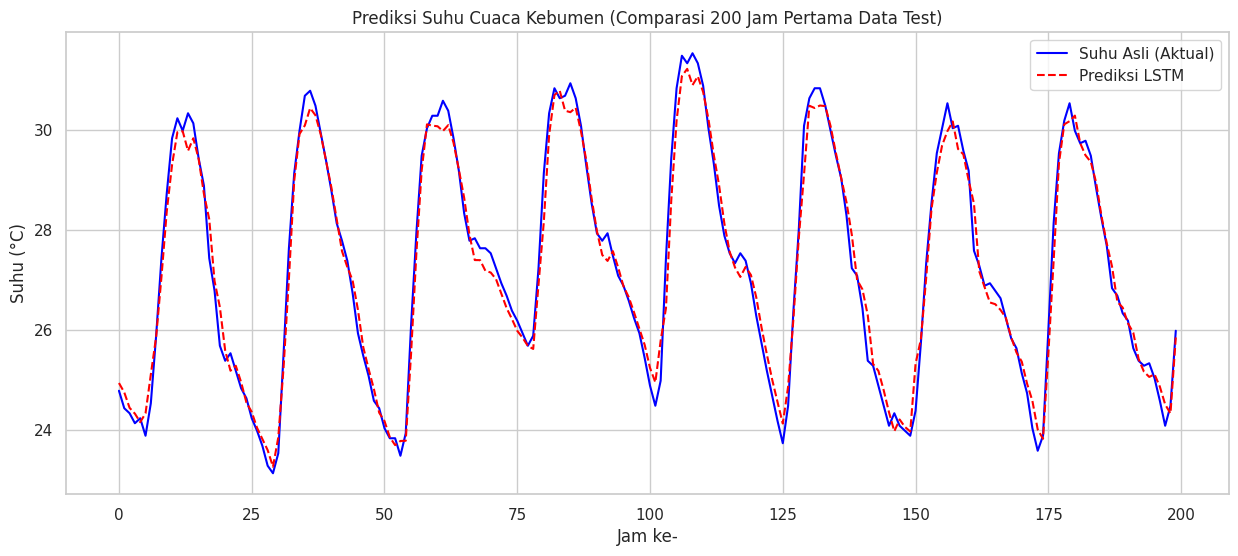

📊 Root Mean Squared Error (RMSE): 0.44 °C
   (Artinya prediksi meleset rata-rata sekitar 0.44 derajat)


In [28]:
# ==========================================
# 7. EVALUASI & PREDIKSI
# ==========================================
# Prediksi data test
y_pred = model.predict(X_test)

# Kembalikan ke skala asli (Inverse Transform)
# Karena scaler kita punya 5 kolom, kita harus bikin dummy array biar pas strukturnya
def inverse_transform_target(pred_value, scaler):
    # Buat array kosong seukuran fitur
    dummy = np.zeros((len(pred_value), len(features)))
    # Isi kolom target (kolom ke-0 adalah temperature sesuai urutan 'features' di atas)
    dummy[:, 0] = pred_value.flatten()
    # Inverse
    inversed = scaler.inverse_transform(dummy)
    return inversed[:, 0]

y_test_inv = inverse_transform_target(y_test.reshape(-1, 1), scaler)
y_pred_inv = inverse_transform_target(y_pred, scaler)

# Plot Hasil Prediksi vs Asli
plt.figure(figsize=(15, 6))
# Ambil 200 jam terakhir biar kelihatan detailnya
range_plot = 200 
plt.plot(y_test_inv[:range_plot], label='Suhu Asli (Aktual)', color='blue')
plt.plot(y_pred_inv[:range_plot], label='Prediksi LSTM', color='red', linestyle='--')
plt.title(f'Prediksi Suhu Cuaca Kebumen (Comparasi {range_plot} Jam Pertama Data Test)')
plt.xlabel('Jam ke-')
plt.ylabel('Suhu (°C)')
plt.legend()
plt.show()

# Hitung Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f"📊 Root Mean Squared Error (RMSE): {rmse:.2f} °C")
print(f"   (Artinya prediksi meleset rata-rata sekitar {rmse:.2f} derajat)")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=672c3bf7-b636-46e8-b7c0-4f6feec29313' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>